# Feature engineering

Now that the data has been cleaned, it can be properly explored and analyzed. The purpose of this part of the process will be to analyze the characteristics of the data and how it can be used in a neural network model for it's forecasting. Particularly I will:
- Plot the data for each pollutant
- Find the correlation between pollutants and the rest of the features
- Remove outliers
- Interpolate missing values
- Create datasets for each pollutant

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore # For outliers

In [ ]:
filepath = "datasets/semadet-tlaquepaque-2023.csv"
df = pd.read_csv(filepath, parse_dates=[0], index_col=0)

## Feature exploration

### Correlation Matrix

Firstly, I would like to look at the realtionships between the features to determine dependencies.

In [67]:
features = df.columns.values
print(features)

['o3' 'pm10' 'pm25' 'tmp' 'rh' 'ws' 'pp' 'wd']


The pollutants with most correlation are PM2.5 with PM10, meanwhile the other non-pollutant features seem to be pretty correlated between themselves and somewhat related to the pollutants.

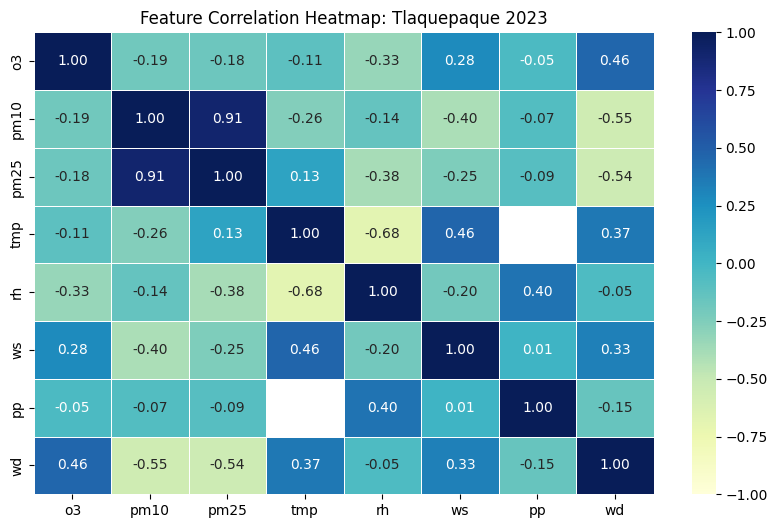

In [68]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5, vmin=-1, vmax=1
)

# Formatting
plt.title("Feature Correlation Heatmap: Tlaquepaque 2023")
plt.savefig(f"graphs/correlation_matrix/correlation.png")
plt.show()

### Plotting data points

This part is mainly to see how the data is distributed, it's tendencies, patterns, trends and seasonality. It'll also help me identify the amount of null values and outliers compared to regular values, in a visual manner.

By looking at the plots:
- The precipitation feature (pp) doesn't seem to hold any relevant information and in the correlation matrix doesn't seem to have important relationships, so it'll be dropped.
- O3 has lots of missing data.
- Wind (wd) is sparse.
- PM 2.5 and PM 10 have very similar values (as confirmed in correlation matrix).
- Temperature increases but has lots of missing data as well.

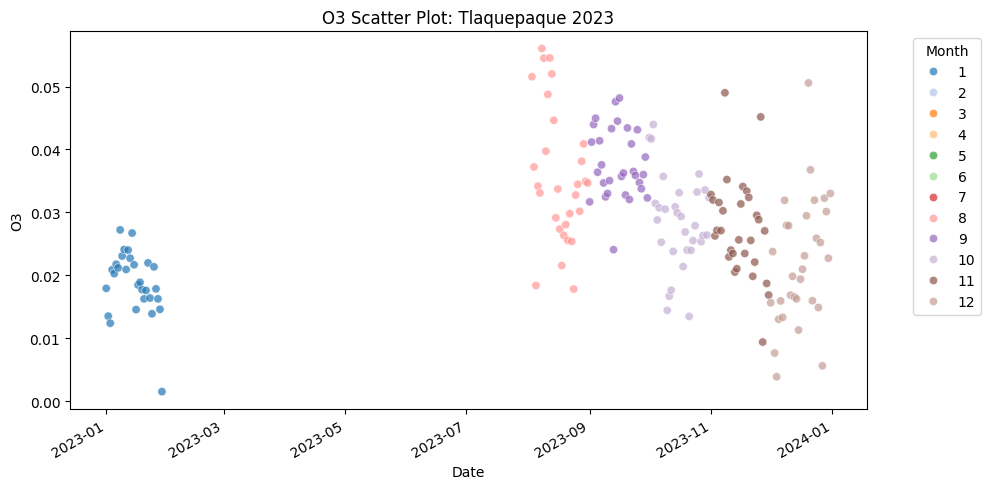

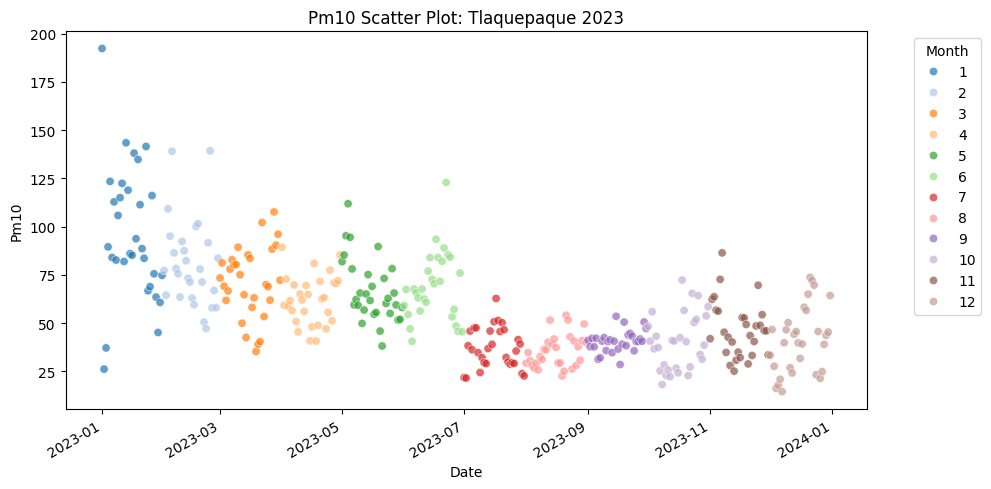

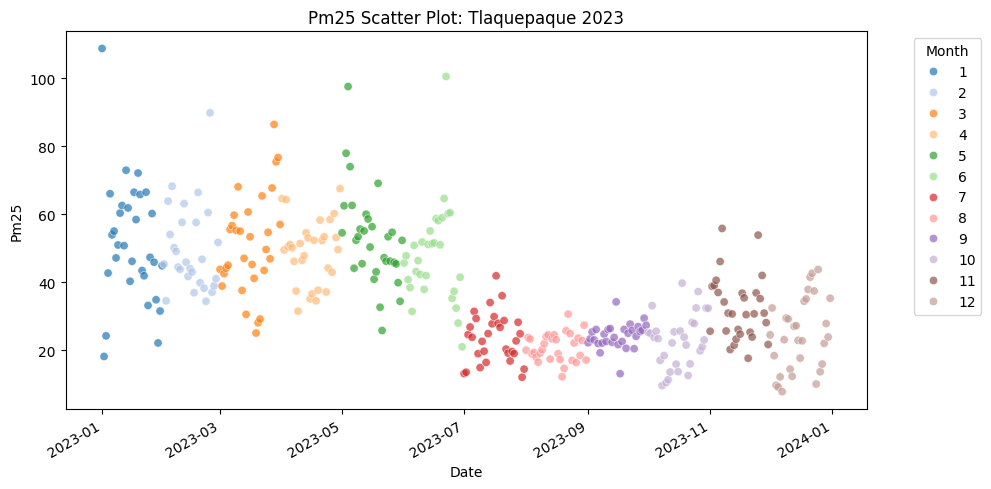

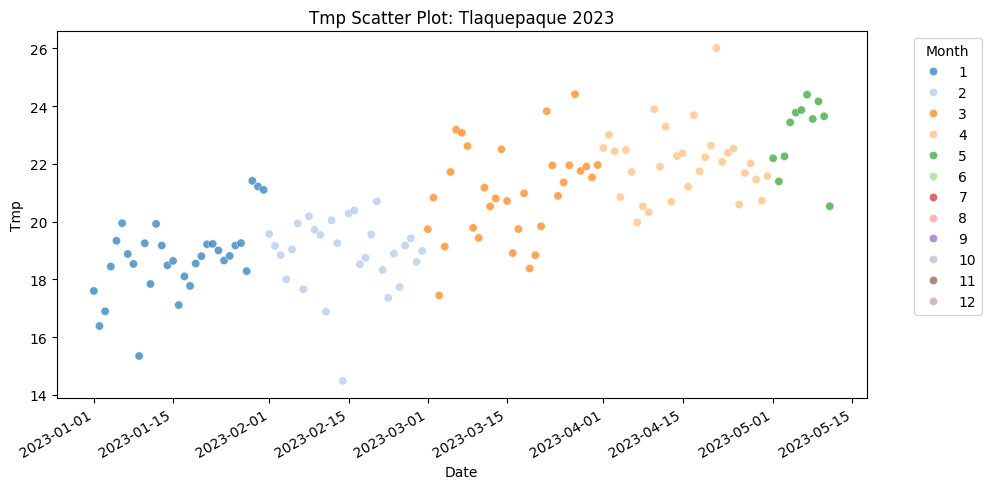

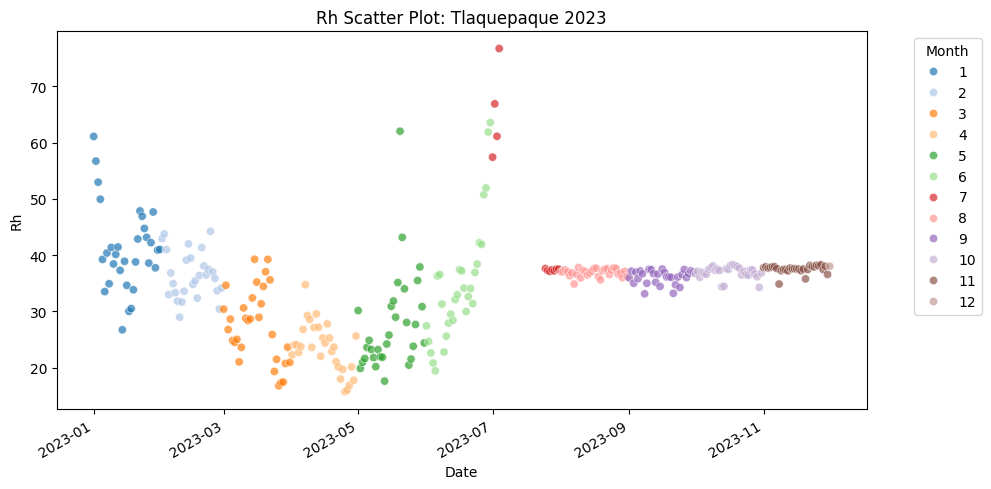

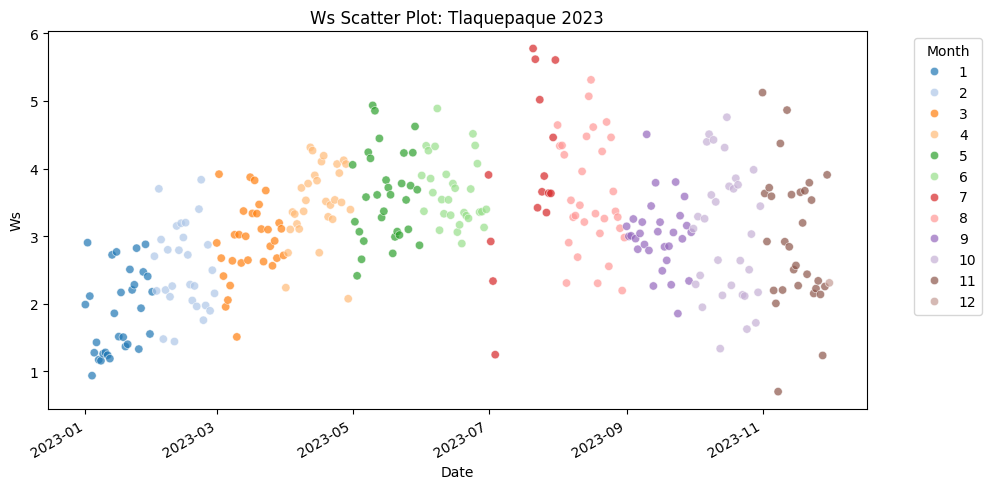

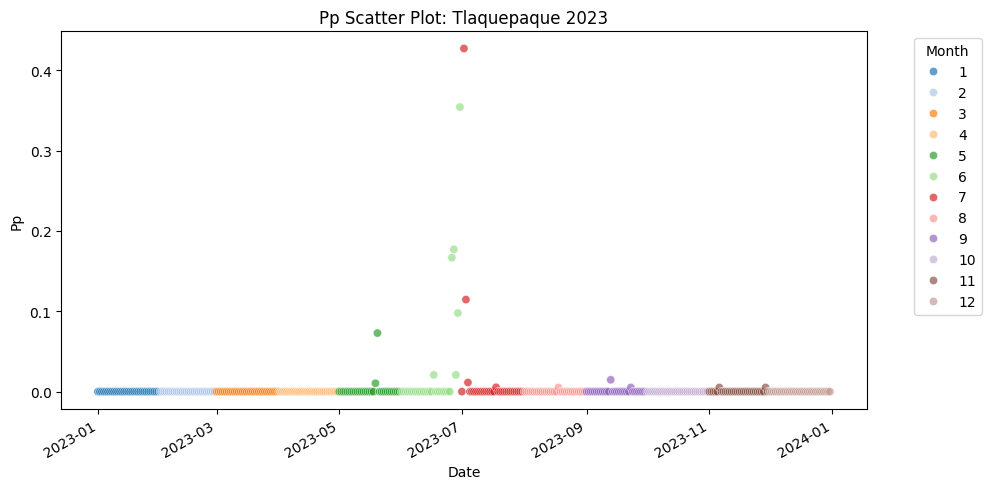

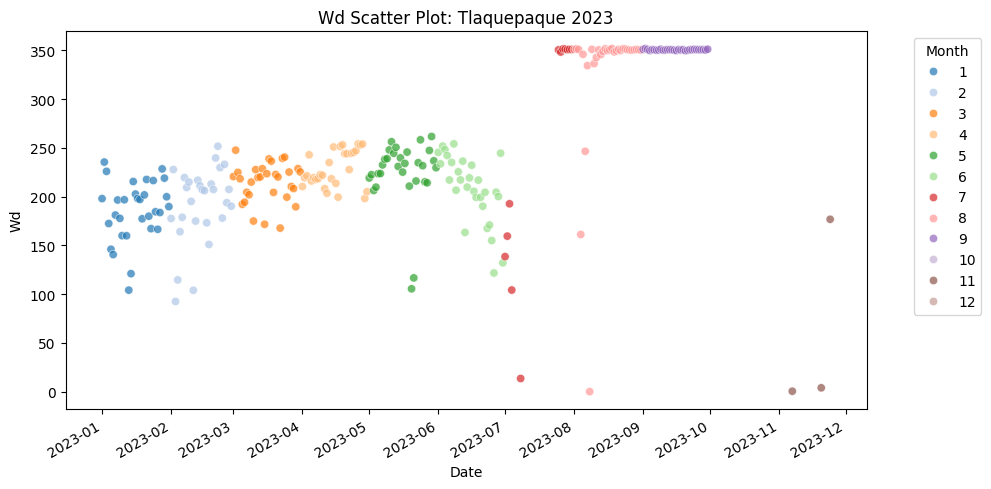

In [69]:
# Create dates and values to np arrays
dates = df.index
months = df.index.month

for feature in features:
    # Scatter plot
    plt.figure(figsize=(10, 5))
    scatter = sns.scatterplot(
        x=dates, y=df[feature], hue=months, palette="tab20", alpha=0.7
    )

    # Formatting
    scatter.set(xlabel="Date", ylabel=feature.capitalize())
    plt.title(f"{feature.capitalize()} Scatter Plot: Tlaquepaque 2023")
    plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.gcf().autofmt_xdate()  # Rotate x-axis labels for better readability
    plt.tight_layout()
    # plt.savefig(f"graphs/scatterplot/{feature}_scatter.png")
    plt.show()

In [70]:
df.drop("pp", axis="columns", inplace=True)

## Filling in data

In this section I will:
- Plot outliers for each feature.
- Identify and remove outlier.
- Interpolate missing data.

### Identify and remove outliers

Before interpolating the data, I'll identify the outliers in each feature and smooth them out so the data doesn't produce overfitting during model training. By plotting the data, I can visually identify the quartiles of the data, median, max and min of data and the outliers.

In [71]:
df.describe()

,o3,pm10,pm25,tmp,rh,ws,wd
count,180.000000,365.000000,365.000000,131.000000,315.000000,319.000000,257.000000
mean,0.028333,57.005197,37.440756,20.411283,34.323550,3.110053,240.511624
std,0.010453,25.760991,17.257236,2.057666,8.501267,0.915655,74.782785
min,0.001500,14.432500,7.841818,14.480000,15.733333,0.701250,0.084108
25%,0.021021,39.037083,23.809412,18.896429,29.120833,2.479792,199.904481
50%,0.027875,51.574167,35.081250,20.323529,36.475000,3.129167,224.914170
75%,0.034510,71.287500,50.175238,21.944862,37.580707,3.699375,334.368513
max,0.056042,192.356957,108.799545,26.009091,76.745455,5.776154,351.951809


#### Plot outliers

In [72]:
features = df.columns.values
print(features)

['o3' 'pm10' 'pm25' 'tmp' 'rh' 'ws' 'wd']


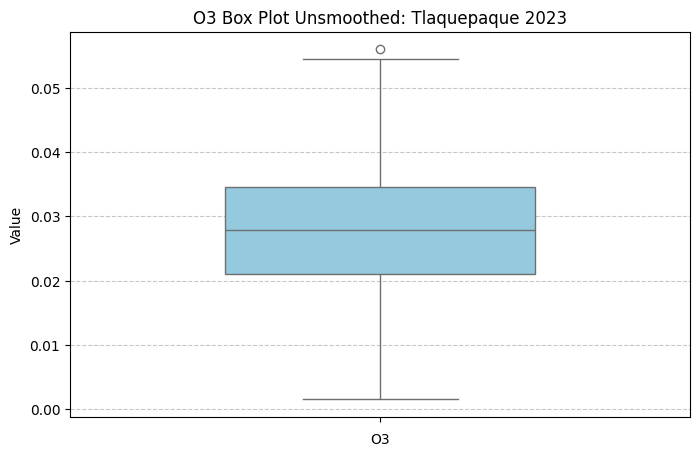

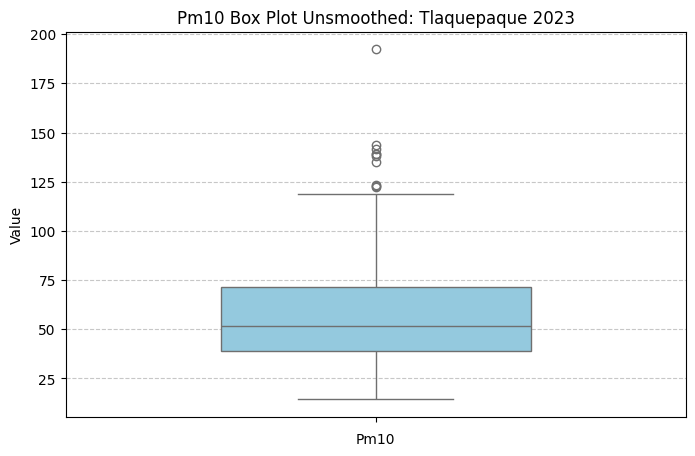

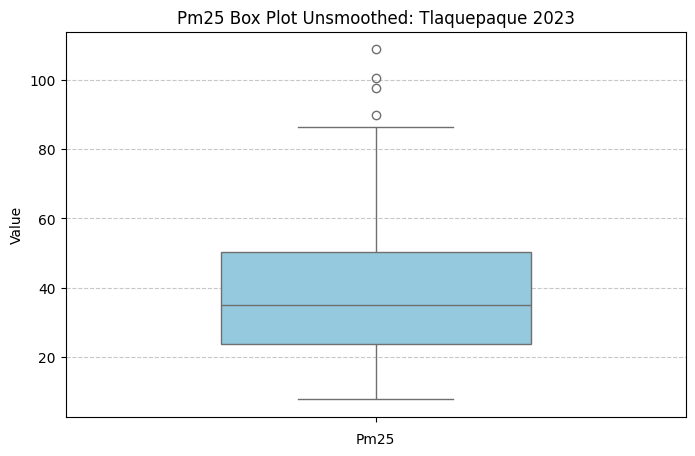

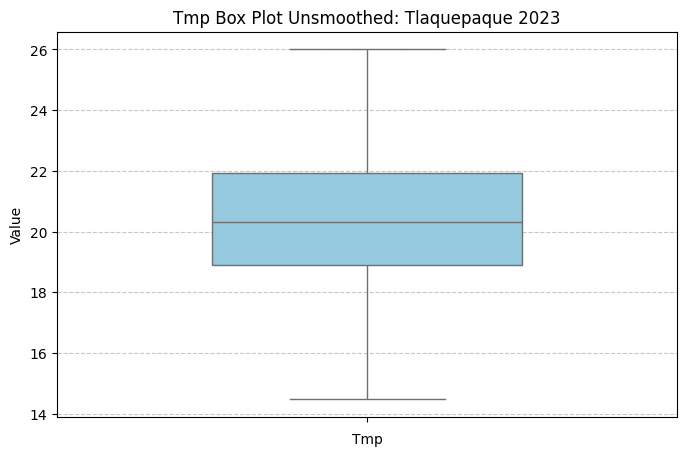

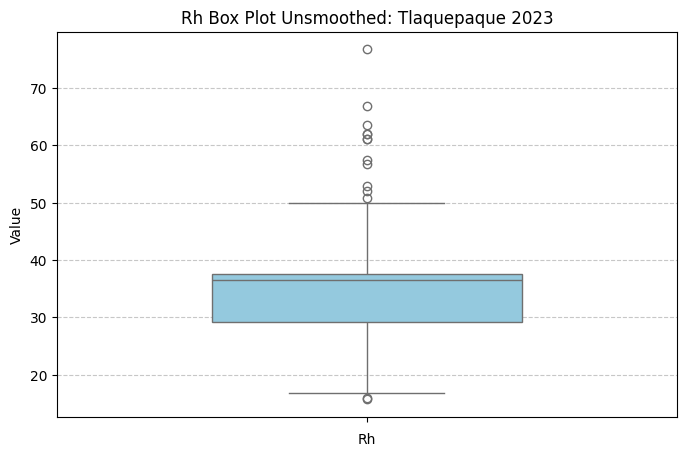

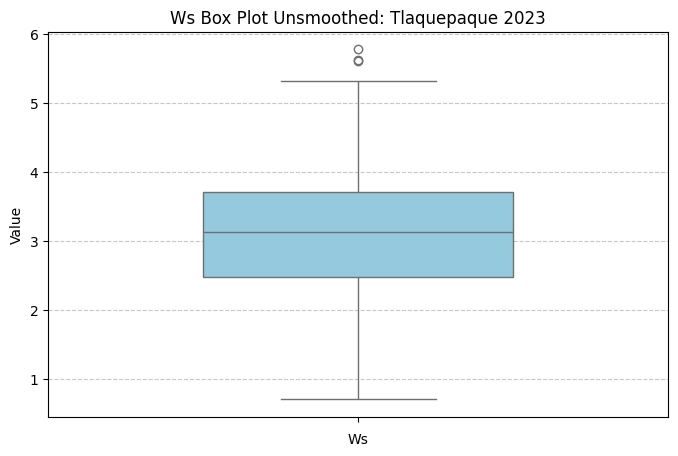

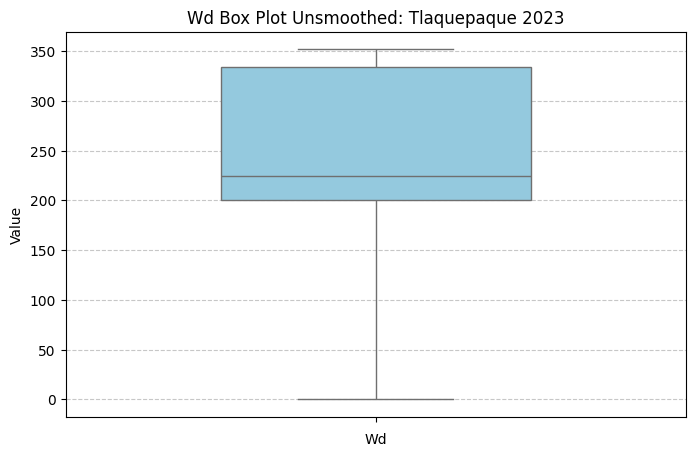

In [73]:
for feature in features:  
    # Box plot
    plt.figure(figsize=(8, 5))
    box = sns.boxplot(y=df[feature], color="skyblue", width=0.5)

    # Formatting
    box.set(xlabel=feature.capitalize(), ylabel="Value")
    plt.title(f"{feature.capitalize()} Box Plot Unsmoothed: Tlaquepaque 2023")
    plt.grid(axis="y", linestyle="--", alpha=0.7)  
    # plt.savefig(f"graphs/boxplot/{feature}_boxplot.png")
    plt.show()

#### Remove outliers

As seen in the boxplot, all features except wind and temperature have outliers that need to be smoothed.

In [74]:
def remove_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    z_scores = np.abs(zscore(series, nan_policy='omit'))  # Handle NaN safely
    return series.where(z_scores < threshold, np.nan)

def remove_outliers_z(features, df):
    # find and replace outliers with null
    for feature in features:
        df[feature] = remove_outliers_zscore(df[feature])
    return df


In [75]:
features = ['o3', 'pm10', 'pm25', 'rh', 'ws']



In [76]:
df_smoothed = remove_outliers_z(features, df)

In [77]:
df_smoothed["wd"] = df["wd"]
df_smoothed["tmp"] = df["tmp"]

#### Interpolate missing values

Once the data has been smoothed, I can now interpolate the missing data. The interpolation methods that I will be using will be:
- **Forward Fill:** Carries previous data forward.
- **Backward Fill:** Carrios previous data backward.
- **Linear interpolation (for any left out values):** Inserts value between the data points assuming there is a line or curve to the data.

In [98]:
features = df_smoothed.columns
df_interpolated = df_smoothed.copy()

In [99]:
for feature in features:
    df_interpolated[feature] = df_interpolated[feature].ffill().bfill().interpolate(method="linear")
    

In [104]:
df_interpolated.head()

,o3,pm10,pm25,tmp,rh,ws,wd
date,,,,,,,
2023-01-01,0.017917,26.115000,18.194167,17.595652,56.725000,1.988750,198.013158
2023-01-02,0.013500,26.115000,18.194167,16.381250,56.725000,2.904583,235.478057
2023-01-03,0.012375,37.117917,24.248333,16.889474,52.979167,2.114167,225.967935
2023-01-04,0.020875,89.490417,42.726250,18.440909,49.941667,0.937500,172.467173
2023-01-05,0.020250,123.436250,66.064167,19.333333,39.241667,1.276667,146.064584


As can be seen, there are no more null values in the data.

In [100]:
df_interpolated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2023-01-01 to 2023-12-31
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   o3      365 non-null    float64
 1   pm10    365 non-null    float64
 2   pm25    365 non-null    float64
 3   tmp     365 non-null    float64
 4   rh      365 non-null    float64
 5   ws      365 non-null    float64
 6   wd      365 non-null    float64
dtypes: float64(7)
memory usage: 22.8 KB


## Save data

In [ ]:
df_interpolated.to_csv('datasets/semadet-tlaquepaque-2023-interpolated.csv')